# Imports

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [14]:
batch_size = 50
image_size = 96

# Create a new transformation that resizes the images
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Load STL-10 dataset
train_dataset = STL10(root='./data', split='train', transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = STL10(root='./data', split='test', transform=transform, download=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Settings

In [15]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in encoder
ndf = 96

# Number of training epochs
num_epochs = 100


# Learning rate for optimizers
lr=0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Weight  Decay
weight_decay = 0.0004


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Supervised Encoder Model

In [16]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c

# Load Pretrained Weights
encoder = Encoder(ngpu=0, dim_z=64, num_classes=10).to(device)
PATH='/data/users2/jwardell1/dcgan-project/models/ae_pretraining_0.0001_256_0.0004.pth'
encoder.main.load_state_dict(torch.load(PATH))
encoder

Encoder(
  (main): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(768, 64, kernel_size=(6, 6), stride=(1, 1), bias=False)
  )
  (fc): Linear(in_features=64, out_features=10, bias=True

# Criterion / Loss Function

In [17]:
criterion = nn.CrossEntropyLoss()

# Optimizer

In [18]:
optimizer = optim.Adam(encoder.parameters(), lr=lr, weight_decay=0)

# Training Loop

In [19]:
# set up wandb
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="dcgan-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
    "architecture": "Encoder Finetuning",
    "dataset": "STL-10",
    "epochs": num_epochs,
    }
)

In [20]:
# Training loop
best_loss = float('inf')
best_model_state = None
num_train = len(train_dataset)




# Set up total loss/acc trackers
all_loss = []
all_acc = []
all_correct = 0
train_running_total = 0



# Set up epochal loss/acc trackers
epoch_loss = []
epoch_acc = []


# Set up validation loss/acc trackers
val_loss = []
val_acc = []
val_running_total = 0




print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # Refresh Epoch Statistics
    print('reset epoch statistics')
    epoch_correct = 0
    epoch_loss_val = 0


    # Set Network to Train Mode
    encoder.train()


    # For each batch in the dataloader
    for i, (data, labels) in enumerate(train_loader, 0):
        # Put train data to device (CPU, GPU, or TPU)
        data_real = data.to(device)
        labels = labels.to(device)

        #  what does this do? why is this needed here?
        optimizer.zero_grad()

        # Forward pass batch through D
        output = encoder(data_real)


        # Calculate loss on batch
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()



        # Compute Predicted Labels for a Batch in Training Dataset
        predicted = torch.argmax(output.data, dim=1).to(device)



        correct = (predicted == labels).sum().item()






        # Update All Data
        all_loss.append(loss.item())

        all_correct += correct
        train_running_total += labels.size(0)


        # Compute All Loss/Acc at each datapoint
        all_accuracy = all_correct / train_running_total
        all_acc.append(all_accuracy)

        print(f'iteration {i} current loss: {loss.item()} current acc: {all_accuracy}')


        # Update Epoch Data
        epoch_correct += correct
        epoch_loss_val += loss.item()


    wandb.log({"TrainLoss": loss.item()})
    wandb.log({"TrainAccuracy": all_accuracy})
    
    # Compute Epoch Loss/Acc at end of Epoch
    epoch_accuracy = epoch_correct / num_train
    epoch_acc.append(epoch_accuracy)

    avg_epoch_loss = epoch_loss_val / len(train_loader)
    epoch_loss.append(avg_epoch_loss)

    print(f'\t\tEpoch {epoch}/{num_epochs} complete. Epoch loss {avg_epoch_loss} Epoch accuracy {epoch_accuracy}')

    # Validation Step
    print('Starting Validation Loop...')



    # Refresh Validation Statistics
    print('reset Validation statistics')
    val_correct = 0
    val_loss_value = 0


    # Set the model to valuation mode
    encoder.eval()


    # Iterate over the validation dataset in batches
    with torch.no_grad():
        for data, labels in test_loader:

            # Put val data to device (CPU, GPU, or TPU)
            data_real = data.to(device)
            labels = labels.to(device)


            # Forward pass batch through D
            output = encoder(data_real)

            # Calculate loss on validation batch
            v_loss = criterion(output, labels)

            # Compute Predicted Labels for a Batch in Validation Dataset
            predicted = torch.argmax(output.data, dim=1).to(device)
            val_correct += (predicted == labels).sum().item()

            # Update Val Data
            val_loss_value += v_loss.item()



    val_accuracy = val_correct / len(test_dataset)
    val_acc.append(val_accuracy)
    wandb.log({"ValidationAccuracy": val_accuracy})

    
    avg_val_loss = val_loss_value / len(test_loader)
    val_loss.append(avg_val_loss)

    print(f"\t\tValidation Epoch {epoch}, Validation Accuracy: {val_accuracy}, Validation Loss: {avg_val_loss}")
    wandb.log({"ValidationLoss": val_loss_value})

    # Update best model if this epoch had the higest accuracy so far
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        print(f'best loss {best_loss}')
        best_model_state = encoder.main.state_dict()



# Save the best model
if best_model_state is not None:
    PATH = '../models/finetuned_encoder_weights_{}_{}_{}.pth'.format(learning_rate, batch_size, weight_decay)
    torch.save(best_model_state, PATH)


Starting Training Loop...
reset epoch statistics
iteration 0 current loss: 2.2734405994415283 current acc: 0.18
iteration 1 current loss: 2.3048720359802246 current acc: 0.14
iteration 2 current loss: 2.2935402393341064 current acc: 0.12666666666666668
iteration 3 current loss: 2.28391170501709 current acc: 0.13
iteration 4 current loss: 2.2932605743408203 current acc: 0.136
iteration 5 current loss: 2.2997336387634277 current acc: 0.12333333333333334
iteration 6 current loss: 2.3006174564361572 current acc: 0.10857142857142857
iteration 7 current loss: 2.296865463256836 current acc: 0.1125
iteration 8 current loss: 2.265316963195801 current acc: 0.12666666666666668
iteration 9 current loss: 2.285517692565918 current acc: 0.124
iteration 10 current loss: 2.269239664077759 current acc: 0.13090909090909092
iteration 11 current loss: 2.289463758468628 current acc: 0.12666666666666668
iteration 12 current loss: 2.2634096145629883 current acc: 0.13230769230769232
iteration 13 current loss: 

NameError: name 'learning_rate' is not defined

# Imports

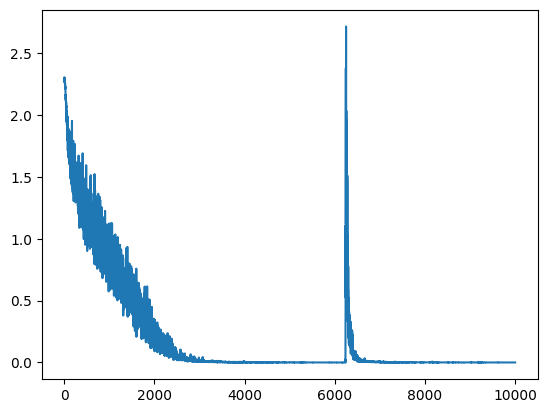

In [21]:
plt.plot(all_loss)

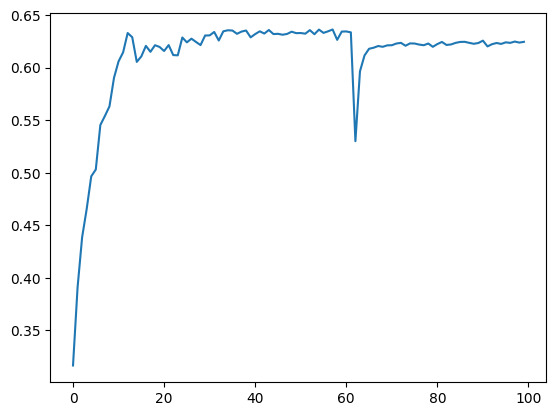

In [22]:
plt.plot(val_acc)


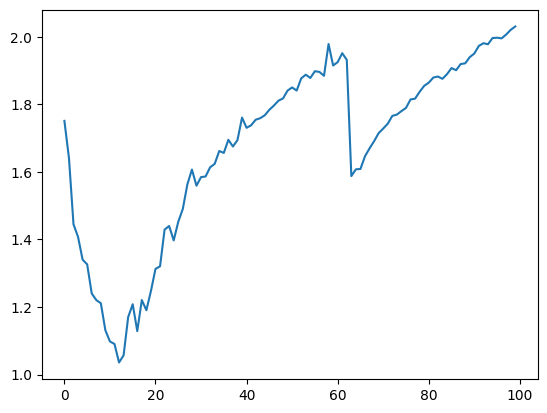

In [23]:
plt.plot(val_loss)

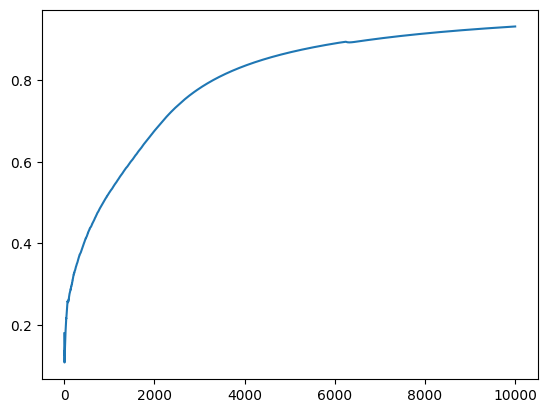

In [24]:
plt.plot(all_acc)

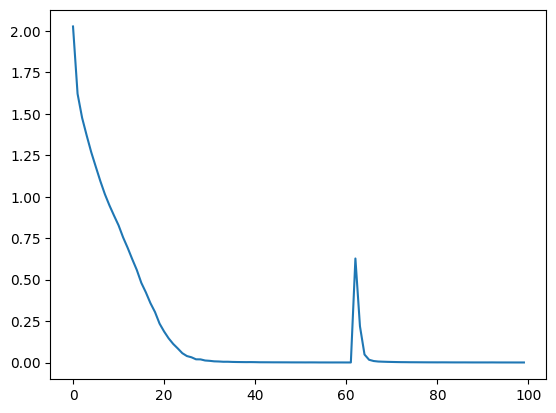

In [25]:
plt.plot(epoch_loss)

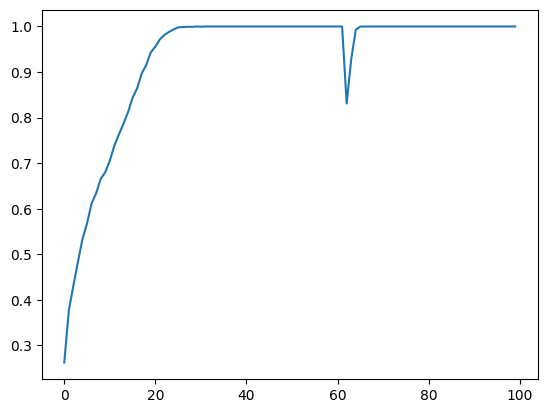

In [26]:
plt.plot(epoch_acc)

In [27]:
wandb.finish()

TrainAccuracy,▁▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
TrainLoss,█▇▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ValidationAccuracy,▁▄▅▆▇█▇██▇███████████████▇██████████████
ValidationLoss,▆▄▃▂▁▁▂▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇█▇▅▅▆▆▆▆▇▇▇▇▇████
TrainAccuracy,0.93151
TrainLoss,0.0002
ValidationAccuracy,0.62462
ValidationLoss,324.88838
